# A Visualisation of My Anime Watch History

In [1]:
import mal_api
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# get the anime list
anime_list = mal_api.get_user_anime_list("Pomtam", fields = "list_status, genres", sort="list_updated_at", limit=1000)
print(json.dumps(anime_list, indent=4))

[
    {
        "node": {
            "id": 47917,
            "title": "Bocchi the Rock!",
            "main_picture": {
                "medium": "https://cdn.myanimelist.net/images/anime/1448/127956.jpg",
                "large": "https://cdn.myanimelist.net/images/anime/1448/127956l.jpg"
            },
            "genres": [
                {
                    "id": 52,
                    "name": "CGDCT"
                },
                {
                    "id": 4,
                    "name": "Comedy"
                },
                {
                    "id": 19,
                    "name": "Music"
                }
            ]
        },
        "list_status": {
            "status": "completed",
            "score": 9,
            "num_episodes_watched": 12,
            "is_rewatching": false,
            "updated_at": "2024-12-27T06:06:53+00:00",
            "finish_date": "2023-12-01"
        }
    },
    {
        "node": {
            "id": 35677,
            "t

##### Setup: Create Data Frames

In [12]:
# Flatten data 
df = pd.json_normalize(anime_list)

# Extract relevant fields and take only completed anime
df = df[df['list_status.status'] == 'completed']
df = df.filter(['node.title','node.genres', 'list_status.score', 'list_status.finish_date']).rename(
    columns={
        'node.title': 'Title',
        'node.genres': 'Genres',
        'list_status.score': 'Score',
        'list_status.finish_date': 'FinishDate'
    }
)

# Explode the genres column - take only genre names
df = df.explode('Genres')
df['Genres'] = df['Genres'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Convert finish date to datetime
df['FinishDate'] = pd.to_datetime(df['FinishDate'])  

# Styles
plt.style.use('seaborn-v0_8-deep')


### Visualisations

##### How much have I been watching?

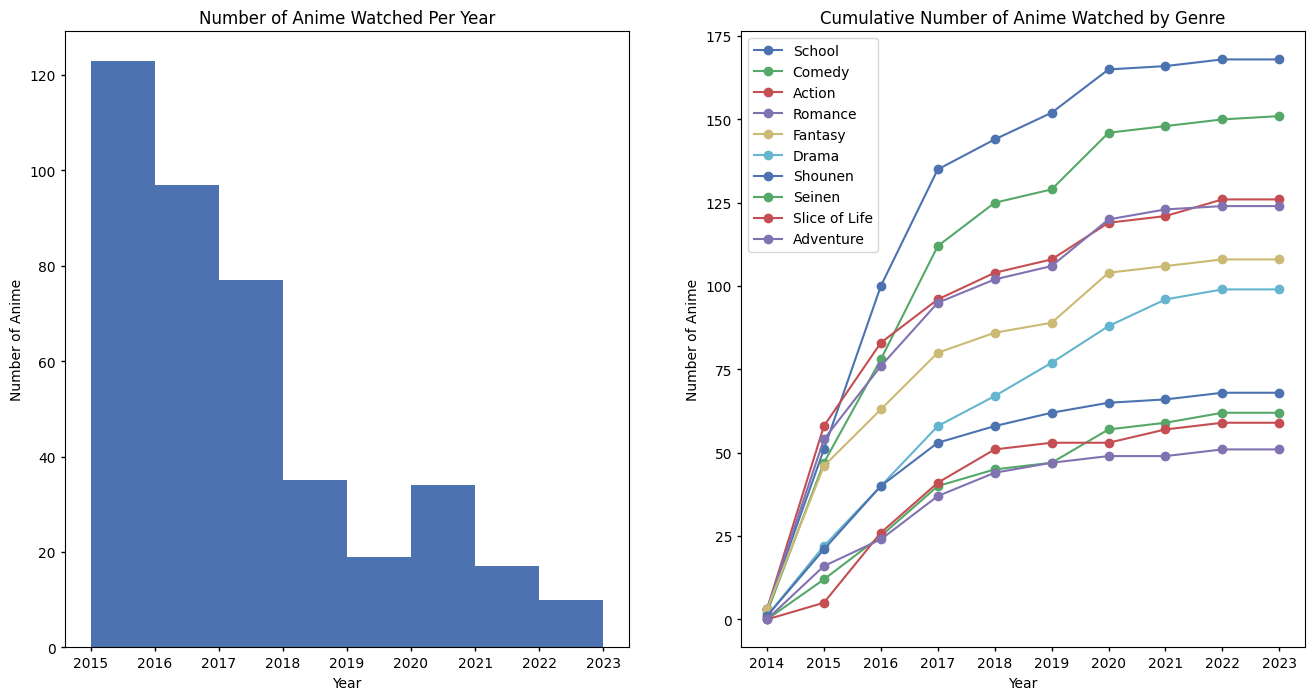

In [3]:

fig, ax = plt.subplots(1, 2, figsize=(16, 8))


## Number if Anime Watched Per Year
df_unique = df.drop_duplicates(subset='Title', keep='first')                                # Keep only the first instance of each anime
df['finish_year'] = df['FinishDate'].dt.year                                                # Extract year from finish date

ax[0].hist(df_unique['FinishDate'], 
           bins=pd.date_range(start=df_unique['FinishDate'].min(), 
                              end=df_unique['FinishDate'].max(), freq='YE'))                # Plot the number of anime watched per year
ax[0].set_title('Number of Anime Watched Per Year')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Anime')
ax[0].tick_params(which='both', direction='out', length=3, width=1, colors='black')


## Breakdown by Genre
counts = df.groupby(['Genres', 'finish_year'])['Title'].count().unstack(fill_value=0)       # Count the number of anime watched per genre/year combination
cumulative_counts = counts.cumsum(axis=1)                                                   # Calculate the cumulative count of anime watched by genre
top_genres = cumulative_counts.iloc[:, -1].nlargest(10).index                               # Get the top 10 genres by cumulative count

for genre in top_genres:                                                                    # Plot the cumulative count of anime watched by genre
    ax[1].plot(cumulative_counts.columns, 
               cumulative_counts.loc[genre], 
               label=genre, 
               marker='o')

ax[1].set_title('Cumulative Number of Anime Watched by Genre')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of Anime')
ax[1].set_xticks(cumulative_counts.columns)
ax[1].tick_params(which='both', direction='out', length=3, width=1, colors='black')
ax[1].legend()

##### Favourites

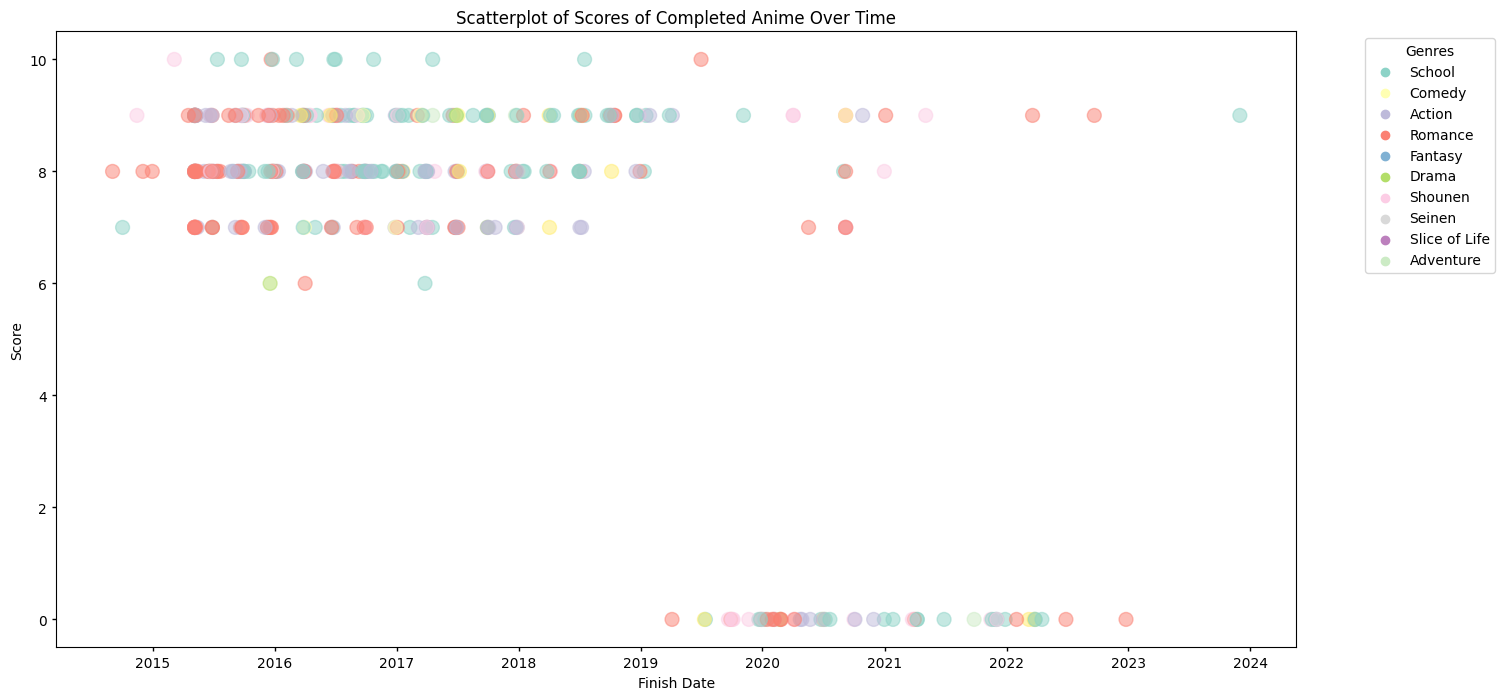

In [4]:
## A Score-FinishDate Scatter Plot, with the color of the points indicating the genre of the anime
fig, ax = plt.subplots(figsize=(16, 8))

ax.scatter(df_unique['FinishDate'], 
              df_unique['Score'], 
              c=df_unique['Genres'].apply(lambda x: top_genres.get_loc(x) if x in top_genres else -1), 
              cmap = 'Set3',
              alpha=0.5,
              s=100)
ax.set_xlabel('Finish Date')
ax.set_title('Scatterplot of Scores of Completed Anime Over Time')
ax.set_ylabel('Score')
ax.tick_params(which='both', direction='out', length=3, width=1, colors='black')

# Create legend handles
legend_elements = [plt.scatter([], [], c=[plt.cm.Set3(i/len(top_genres))], label=genre)
                  for i, genre in enumerate(top_genres)]

# Add legend
ax.legend(handles=legend_elements, title="Genres", 
         bbox_to_anchor=(1.05, 1), loc='upper left')

## A Score Horizontal Bar Plot Proportional to the Number of Anime Watched and coloured by Genre


In [ ]:
import plotly.express as px

# Filter out the top genres
df_filtered = df[df['Genres'].isin(top_genres)]
df["Genres Combined"] = df.groupby('Title')['Genres'].transform(lambda x: ', '.join(x.unique()))

# Create the scatter plot
fig = px.scatter(df_filtered,
                 x='FinishDate', 
                 y='Score',
                 color='Genres',
                 hover_data={'Title': True, 'Genres Combined': True, 'Genres':False},  # Show combined genres on hover
                 title='Scatterplot of Scores of Completed Anime Over Time',
                 color_discrete_sequence=px.colors.qualitative.Set3)

# Increase dot size
fig.update_traces(marker=dict(size=12))  # Adjust size to your preference

# Update layout
fig.update_layout(
    xaxis_title='Finish Date',
    yaxis_title='Score',
    legend_title='Genres',
    height=600,
    width=1200,
    xaxis=dict(
        tickmode='linear',
        dtick='M12',  # Set tick interval to 1 year
        tickformat='%Y'  # Format ticks as years
    )
)

fig.show()



In [13]:
import seaborn as sns

# Create a violin plot or box plot
plt.figure(figsize=(16, 8))
sns.violinplot(data=df_exploded,
               x='Genres',
               y='Score',
               palette='husl')
plt.xticks(rotation=45)
plt.title('Score Distribution by Genre')

ModuleNotFoundError: No module named 'seaborn'

In [6]:
# Update a score
# update_score = mal_api.update_anime_status(animeId=47917, finish_date="2023-12-01", score=9)
# update_score = mal_api.update_anime_status(animeId=47917, score=3)

print(cumulative_counts.iloc[:, -1].nlargest(10).index)

Index(['School', 'Comedy', 'Action', 'Romance', 'Fantasy', 'Drama', 'Shounen',
       'Seinen', 'Slice of Life', 'Adventure'],
      dtype='object', name='Genres')
